In [1]:
%matplotlib inline

# Force GeoPandas to use Shapely instead of PyGEOS
# In a future release, GeoPandas will switch to using Shapely by default.
import os
os.environ['USE_PYGEOS'] = '0'

import datacube
import numpy as np
import xarray as xr
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
from IPython.display import Image
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.plotting import map_shapefile, xr_animation
from deafrica_tools.dask import create_local_dask_cluster
from deafrica_tools.spatial import xr_rasterize

In [2]:
create_local_dask_cluster()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/nanaboamah89@gmail.com/proxy/8787/status,
Dashboard: /user/nanaboamah89@gmail.com/proxy/8787/status,Workers: 1
Total threads: 4,Total memory: 26.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34965,Workers: 1
Dashboard: /user/nanaboamah89@gmail.com/proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 26.21 GiB
Comm: tcp://127.0.0.1:42039,Total threads: 4
Dashboard: /user/nanaboamah89@gmail.com/proxy/34769/status,Memory: 26.21 GiB
Nanny: tcp://127.0.0.1:41661,


In [3]:
dc = datacube.Datacube(app='biomass')

In [4]:
# Define the area of interest
vector_file = "../Supplementary_data/MGCI/african_countries.geojson"

# Define the start year and end year
start_year = '2018'
end_year = '2020'

In [5]:
#read shapefile
gdf = gpd.read_file(vector_file)

# Select an African country to carry out the analysis over.
country = "Tunisia"

gdf = gdf.iloc[[47]]

In [6]:
#Create a query object
bbox=list(gdf.total_bounds)
lon_range = (bbox[0], bbox[2])
lat_range = (bbox[1], bbox[3])

query = {
    'x': lon_range,
    'y': lat_range,
    'resolution': (-100, 100),
    'output_crs':'EPSG:6933',
    'time': (start_year, end_year),
    'dask_chunks':dict(x=1000,y=1000)
}

#load wofs
ds = dc.load(product="ndvi_anomaly",
             **query)

print(ds)


<xarray.Dataset> Size: 10GB
Dimensions:           (time: 36, y: 7564, x: 3931)
Coordinates:
  * time              (time) datetime64[ns] 288B 2018-01-16T11:59:59.999999 ....
  * y                 (y) float64 61kB 4.442e+06 4.442e+06 ... 3.685e+06
  * x                 (x) float64 31kB 7.26e+05 7.262e+05 ... 1.119e+06
    spatial_ref       int32 4B 6933
Data variables:
    ndvi_mean         (time, y, x) float32 4GB dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    ndvi_std_anomaly  (time, y, x) float32 4GB dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    clear_count       (time, y, x) int8 1GB dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref


In [7]:
#create mask
mask = xr_rasterize(gdf,ds)

#mask data
ds = ds.where(mask)


In [8]:
#out_path = 'results/biomass.gif'

#xr_animation(ds=ds,
            # output_path=out_path,
            # interval=400,
            # bands=['ndvi_mean'],
            # show_text='Biomass Annual Summary',
           #  show_date = '%Y',
           #  width_pixels=700,
           #  annotation_kwargs={'fontsize': 15},
           #  imshow_kwargs={'cmap': sns.color_palette("mako_r", as_cmap=True), 'vmin': 0.0, 'vmax': 0.9},
           #  colorbar_kwargs={'colors': 'black'},
           #  show_colorbar=False)

# Plot animated gif
#plt.close()
#Image(filename=out_path)

In [9]:
pixel_length = query["resolution"][1]  # in metres
m_per_km = 1000  # conversion from metres to kilometres
area_per_pixel = pixel_length**2 / m_per_km**2

In [10]:
biomass_threshold = 0.1

In [11]:
#threshold
biomass = (ds.ndvi_mean > biomass_threshold).persist()


#calculate area
ds_valid_biomass_area = biomass.sum(dim=['x', 'y']) * area_per_pixel

/usr/local/lib/python3.10/dist-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


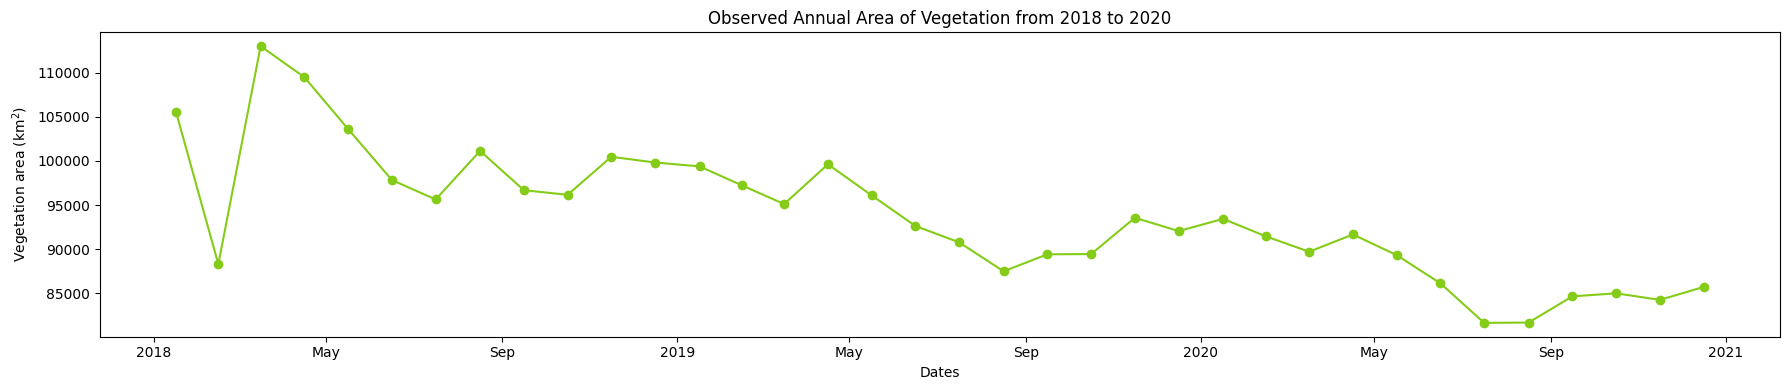

In [12]:
plt.figure(figsize=(18, 4))
ds_valid_biomass_area.plot(marker='o', color='#85cc18')
plt.title(f'Observed Annual Area of Vegetation from {start_year} to {end_year}')
plt.xlabel('Dates')
plt.ylabel('Vegetation area (km$^2$)')
plt.tight_layout()

In [13]:
min_vegetation_area_date, max_vegetation_area_date =  min(ds_valid_biomass_area), max(ds_valid_biomass_area)
time_xr = xr.DataArray([min_vegetation_area_date.time.values, max_vegetation_area_date.time.values], dims=["time"])

print(time_xr)

<xarray.DataArray (time: 2)> Size: 16B
array(['2020-07-16T11:59:59.999999000', '2018-03-16T11:59:59.999999000'],
      dtype='datetime64[ns]')
Dimensions without coordinates: time


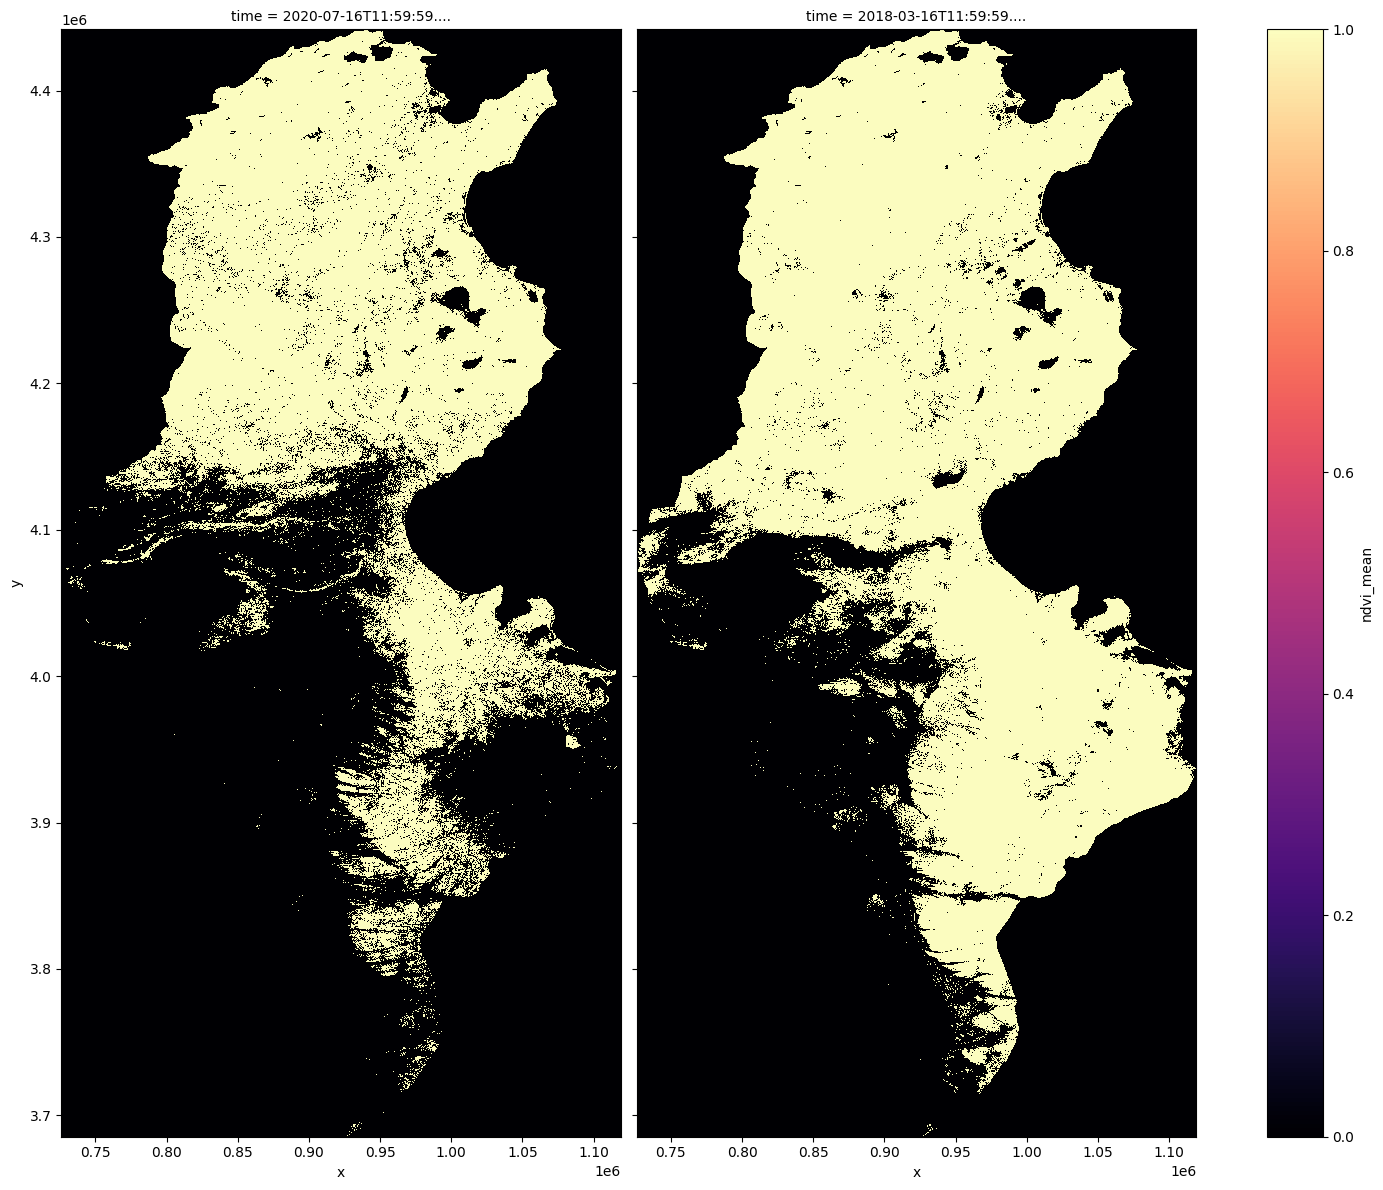

In [14]:
biomass.sel(time=time_xr).plot.imshow(col="time", col_wrap=2, figsize=(15, 12),cmap='magma');

In [15]:
####Compare two time periods 

In [16]:
baseline_time = '2018'
analysis_time = '2019'

baseline_ds, analysis_ds = ds_valid_biomass_area.sel(time=baseline_time), ds_valid_biomass_area.sel(time=analysis_time)

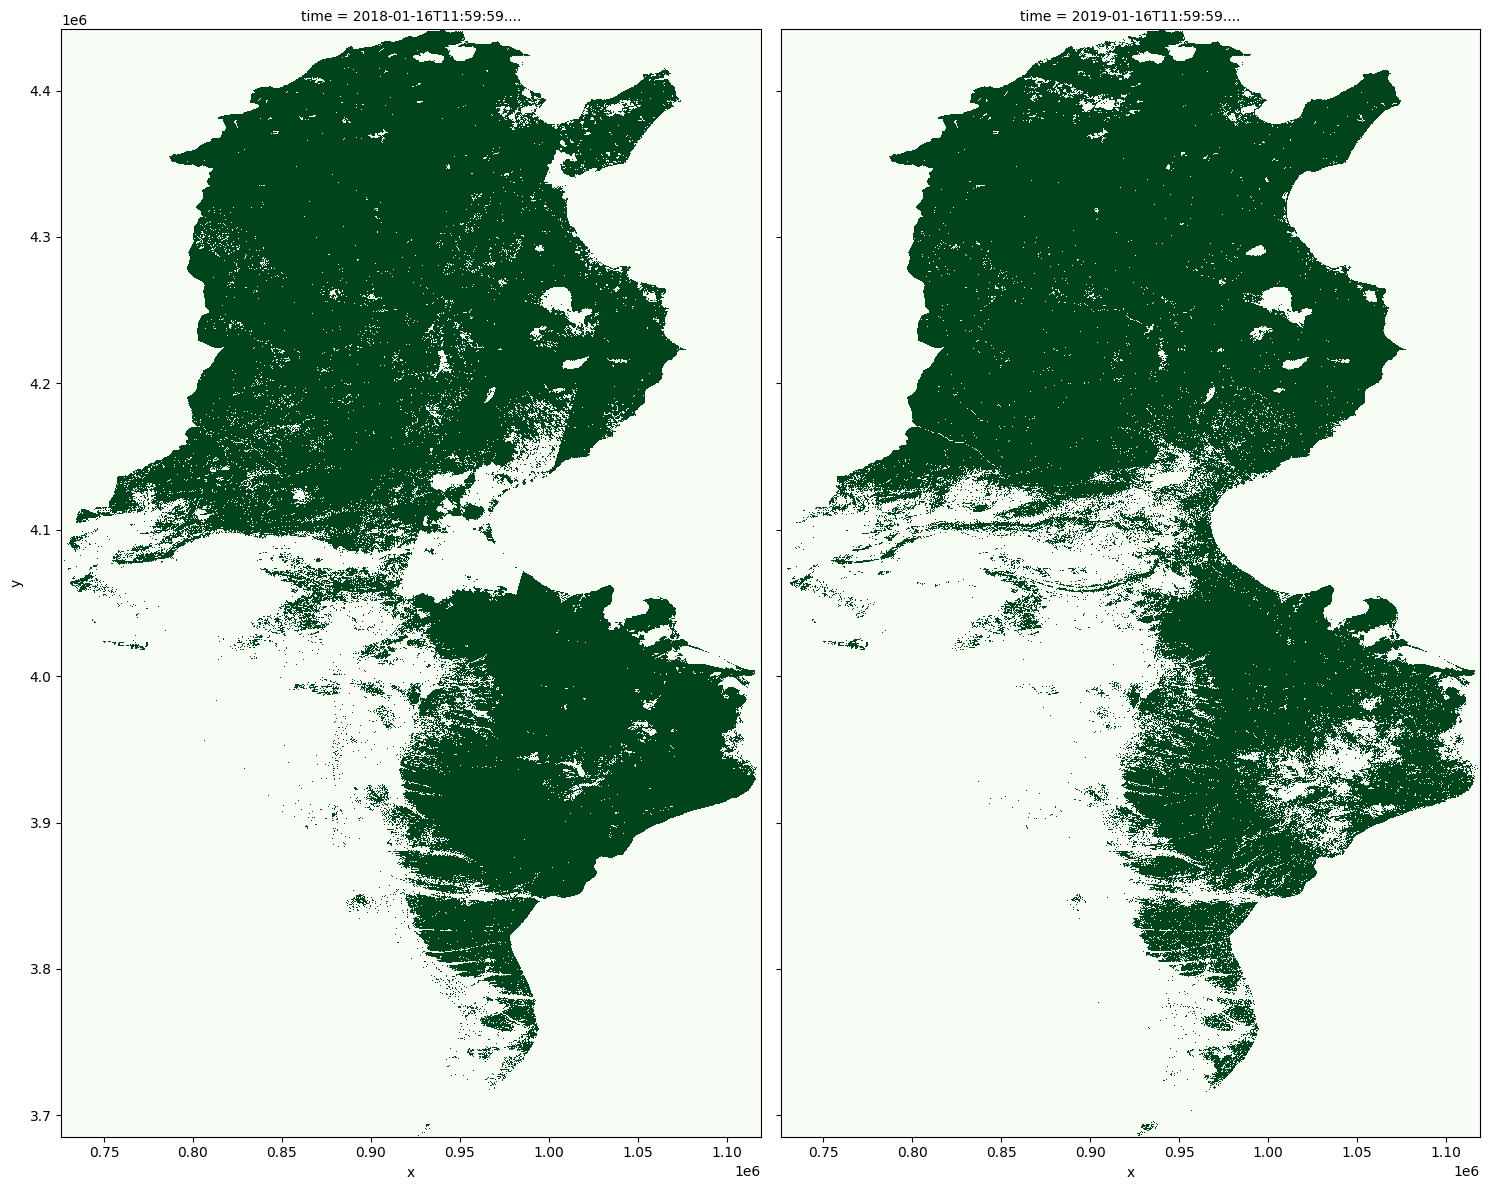

In [17]:
compare = biomass.sel(time=[baseline_ds.time.values[0], analysis_ds.time.values[0]])

compare.plot.imshow(col="time",col_wrap=2,figsize=(15, 12), cmap='Greens', add_colorbar=False);

In [18]:
analyse_total_value = compare.isel(time=1).astype(int)
change = analyse_total_value - compare.isel(time=0).astype(int)

biomass_appeared = change.where(change == 1)
permanent_biomass = change.where((change == 0) & (analyse_total_value == 1))
permanent_land = change.where((change == 0) & (analyse_total_value == 0))
biomass_disappeared = change.where(change == -1)


In [19]:
total_area = analyse_total_value.count().values * area_per_pixel
biomass_apperaed_area = biomass_appeared.count().values * area_per_pixel
stable_biomass_area = permanent_biomass.count().values * area_per_pixel
biomass_disappeared_area = biomass_disappeared.count().values * area_per_pixel

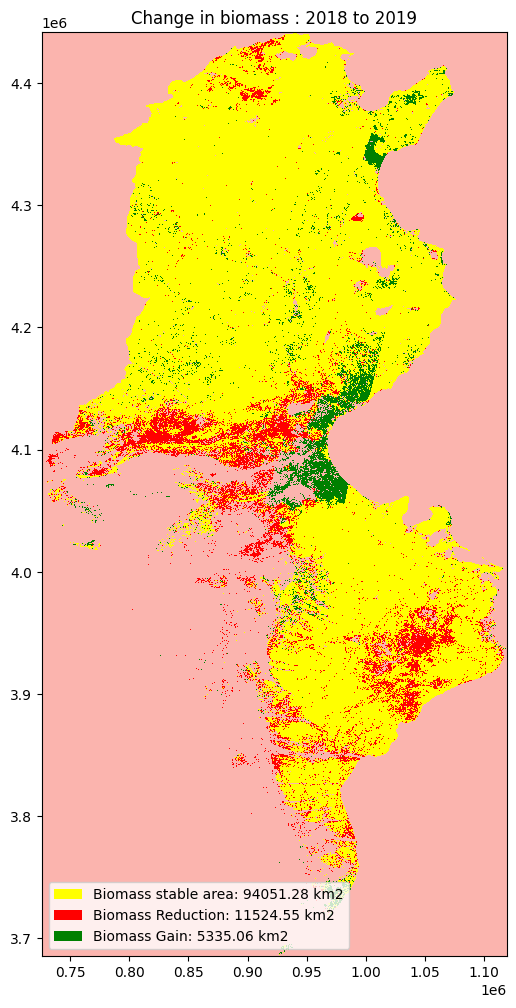

In [20]:
biomass_appeared_color = "Green"
biomass_disappeared_color = "Red"
stable_color = "Yellow"
land_color = "White"

fig, ax = plt.subplots(1, 1, figsize=(6, 12))

compare[1].plot.imshow(cmap="Pastel1",
                                       add_colorbar=False,
                                       add_labels=False,
                                       ax=ax)
biomass_appeared.plot.imshow(
    cmap=ListedColormap([biomass_appeared_color]),
    add_colorbar=False,
    add_labels=False,
    ax=ax,
)
biomass_disappeared.plot.imshow(
    cmap=ListedColormap([biomass_disappeared_color]),
    add_colorbar=False,
    add_labels=False,
    ax=ax,
)
permanent_biomass.plot.imshow(cmap=ListedColormap([stable_color]),
                            add_colorbar=False,
                            add_labels=False,
                            ax=ax)

plt.legend(
    [
        Patch(facecolor=stable_color),
        Patch(facecolor=biomass_disappeared_color),
        Patch(facecolor=biomass_appeared_color),
        Patch(facecolor=land_color),
    ],
    [
        f"Biomass stable area: {round(stable_biomass_area, 2)} km2",
        f"Biomass Reduction: {round(biomass_disappeared_area, 2)} km2",
        f"Biomass Gain: {round(biomass_apperaed_area, 2)} km2",
    ],
    loc="lower left",
)

plt.title("Change in biomass : " + baseline_time + " to " + analysis_time);